In [37]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import pandas as pd
from matplotlib import pyplot as plt
import sklearn
from sklearn.decomposition import PCA
import numpy as np
import datetime

TRAINING_FRACTION = 0.8
N_DENSE = 1
L=32

In [38]:
user = 1
if user == 1:
    prefix_s3 = "/home/owen/"
    prefix_data = "/home/owen/repos/"
elif user == 2:
    prefix_data = "/Users/omyers/repos/"
    
tensorboard_log_dir = "{}/logs/fit/".format(prefix_s3) + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


In [39]:
df_bins = pd.read_csv("{prefix_data}z3support/data/SpinMLData/2DIsing/L-{L}/L-{L}-T-1-5/bins_L-{L}-T-1-5.txt".format(L=L,prefix_data=prefix_data), sep="\t")
df_conf = pd.read_csv("{prefix_data}z3support/data/SpinMLData/2DIsing/L-{L}/L-{L}-T-1-5/spinConfigs_L-{L}-T-1-5.txt".format(L=L,prefix_data=prefix_data), delimiter=r"\s+", header=None)

/home/owen/repos/z3support/pythonenv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3106: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [40]:
df_bins

,# L,T,binNum,E,ESq,AccRate_local,AccRate_clust,sigma,absSigma
0,32,0.25,1,-2,4,0,1,0,1
1,32,0.25,2,-2,4,0,1,0,1
2,32,0.25,3,-2,4,0,1,0,1
3,32,0.25,4,-2,4,0,1,0,1
4,32,0.25,5,-2,4,0,1,0,1
...,...,...,...,...,...,...,...,...,...
200014,32,5,9996,-0.425258,0.183289,0.693285,1,0.002006,0.040533
200015,32,5,9997,-0.432437,0.189161,0.690379,1,-0.000963,0.043111
200016,32,5,9998,-0.422969,0.181396,0.693585,1,-0.004283,0.042318
200017,32,5,9999,-0.427754,0.185275,0.691467,1,-0.003479,0.041635


In [42]:
if L < 32:
    print(df_bins.iloc[1000][1])
else:
    print(df_bins.iloc[10000][1])

 T 


In [43]:
df_bins = df_bins[df_bins[' T '] != ' T ']

In [45]:
df_bins = df_bins.astype(
    {
        " T ": float,
        " binNum": int,
    }
)

In [46]:
df_conf

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,1,1,-1,1,1,1,-1,-1,-1,1,...,1,1,1,1,1,1,-1,-1,-1,1
199996,1,1,-1,-1,-1,-1,1,1,-1,-1,...,-1,-1,1,-1,1,-1,-1,1,-1,1
199997,-1,-1,1,-1,1,-1,-1,-1,-1,1,...,-1,1,-1,1,1,-1,1,1,-1,1
199998,-1,-1,1,1,-1,1,1,-1,1,-1,...,-1,1,1,-1,-1,-1,1,1,1,-1


## Get the temp and magnatization into the configuration dataframe

In [47]:
df_conf["T"] = df_bins[" T "]

In [48]:
df_conf.columns

Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023,  'T'],
      dtype='object', length=1025)

In [49]:
mean_col = df_conf[0].copy()
for i in range(1, L):
    mean_col += df_conf[i]

mean_col /= L

In [50]:
df_conf["M"] = mean_col

# If you want to filter temp do it here

In [51]:
#filterned_confs = df_conf[(df_conf["T"] < 1.5) | (df_conf["T"] > 4.5)]
#filterned_confs = df_conf[(df_conf["T"] > 1.5) | (df_conf["T"] > 4.5)]
filterned_confs = df_conf

In [52]:
train_with_meta_info = filterned_confs.sample(frac=TRAINING_FRACTION, axis=0)
test_with_meta_info = filterned_confs.drop(index=train_with_meta_info.index)
train = train_with_meta_info.drop(["T","M"], axis=1)
test = test_with_meta_info.drop(["T","M"], axis=1)

In [15]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
3677,1,1,-1,1,1,-1,-1,1,-1,1,...,-1,1,-1,1,1,1,1,1,1,1
2651,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,-1
4926,-1,-1,-1,-1,1,1,-1,-1,1,-1,...,-1,1,1,-1,-1,-1,1,1,-1,-1
881,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3433,-1,-1,1,1,1,-1,-1,-1,1,1,...,-1,-1,-1,-1,1,1,1,1,-1,-1


In [16]:
img_pca = PCA(n_components=N_DENSE)

In [17]:
img_pca.fit(train)

PCA(n_components=1)

In [18]:
components = img_pca.transform(filterned_confs.drop(["T","M"], axis=1))

In [19]:
components.shape

(5000, 1)

In [20]:
filterned_confs["T"]

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
4995    5.0
4996    5.0
4997    5.0
4998    5.0
4999    5.0
Name: T, Length: 5000, dtype: float64

In [21]:
if N_DENSE > 1:
    plt.scatter(components[:,0], components[:,1], c=pd.to_numeric(filterned_confs["T"]), alpha=0.1)

In [22]:
if N_DENSE > 1:
    plt.scatter(components[:,0], components[:,1], c=pd.to_numeric(filterned_confs["M"]), alpha=0.1)

AttributeError: 'AxesSubplot' object has no attribute 'flat'

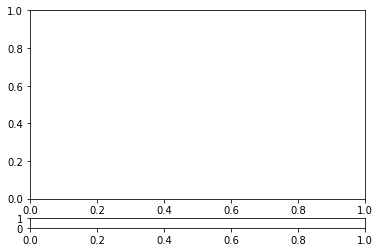

In [23]:
vmax = 0.0
vmin = 0.0
for i in range(N_DENSE):
    if max(img_pca.components_[i]) > vmax:
        vmax = max(img_pca.components_[i])
    
    if min(img_pca.components_[i]) < vmin:
        vmin = min(img_pca.components_[i])
        

fig_pca, (axes_pca, ax_color) = plt.subplots(2,N_DENSE, gridspec_kw={"height_ratios":[1, 0.05]})
im_list = []
for i, ax in enumerate(axes_pca.flat):
    im = ax.imshow(img_pca.components_[i].reshape(L,L), vmin=vmin, vmax=vmax)
    im_list.append(im)

for i, ax in enumerate(ax_color.flat):
    fig_pca.colorbar(im_list[i], cax=ax, orientation="horizontal")
plt.savefig("{}/s3-bucket/ising/pca_weights_as_image_l{}".format(prefix_s3, L))

In [24]:
df_components = pd.DataFrame(data={"c0": components[:,0], "c1": components[:,1], "T": pd.to_numeric(filterned_confs["T"])})

IndexError: index 1 is out of bounds for axis 1 with size 1

In [25]:
component_number = 0
plt.hist(df_components[df_components["T"] > 2]["c{}".format(component_number)], bins=15, color="r")
plt.hist(df_components[df_components["T"] < 2]["c{}".format(component_number)], bins=20, color="y")
#plt.show()
plt.savefig("{}/s3-bucket/reproduction/fig_2/pca_latent_param_hist_l{}.png".format(prefix_s3, L))

NameError: name 'df_components' is not defined

In [ ]:
plt.scatter(pd.to_numeric(filterned_confs["M"]), components[:,0], c=pd.to_numeric(filterned_confs["T"]), alpha=0.1)
plt.xlabel("magnitization")
plt.ylabel("1st")
plt.savefig("{}/s3-bucket/reproduction/fig_2/pca_scatter_latent_vs_mag_color_by_t_l{}.png".format(prefix_s3, L))

# PCA Recreate from latent space

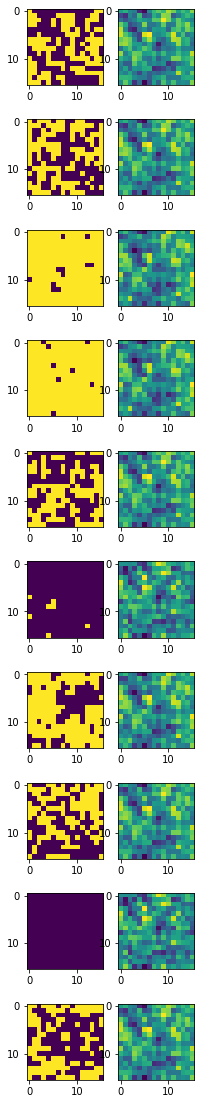

In [26]:

recreate_sample_size = 10

plt.figure(figsize=(3, recreate_sample_size*2))

sampled_look = test.sample(recreate_sample_size)

for i in range(recreate_sample_size):
    
    plt1 = plt.subplot2grid((recreate_sample_size,2), (i,0), colspan=1)
    plt2 = plt.subplot2grid((recreate_sample_size,2), (i,1), colspan=1)
    
    plt1.imshow(
        sampled_look.iloc[i].to_numpy().reshape(L,L)
    )
    plt2.imshow(
        img_pca.inverse_transform(img_pca.transform(sampled_look))[i].reshape(L,L)
    )


# Simple Autoencoder

In [27]:
simp_ae = tf.keras.Sequential(
    [
        keras.layers.InputLayer(input_shape=(L*L,)),
        keras.layers.Dense(N_DENSE, use_bias=False, name='latent_space'),
        keras.layers.Dense(L*L),
    ]
)


2022-08-12 14:45:36.504724: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-12 14:45:36.507902: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-12 14:45:36.508186: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-12 14:45:36.508661: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [28]:
simp_ae.output_shape

(None, 256)

In [29]:
simp_ae.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 latent_space (Dense)        (None, 1)                 256       
                                                                 
 dense (Dense)               (None, 256)               512       
                                                                 
Total params: 768
Trainable params: 768
Non-trainable params: 0
_________________________________________________________________


In [30]:
tb_callback = keras.callbacks.TensorBoard(
    log_dir=tensorboard_log_dir,
    histogram_freq=2,  
    write_graph=True,
    write_images=True
)

In [31]:
tensorboard_log_dir

'/home/owen//logs/fit/20220812-141818'

In [32]:
simp_ae.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [33]:
simp_ae.fit(
    batch_size=16,
    x=filterned_confs.drop(["T","M"], axis=1),
    y=filterned_confs.drop(["T","M"], axis=1),
    epochs=50,
    callbacks=[tb_callback]
)

Epoch 1/50
313/313 [==============================] - 1s 1ms/step - loss: 0.7263 - mae: 0.7339
Epoch 2/50
313/313 [==============================] - 0s 1ms/step - loss: 0.6200 - mae: 0.6233
Epoch 3/50
313/313 [==============================] - 0s 1ms/step - loss: 0.6192 - mae: 0.6234
Epoch 4/50
313/313 [==============================] - 0s 1ms/step - loss: 0.6189 - mae: 0.6236
Epoch 5/50
313/313 [==============================] - 0s 1ms/step - loss: 0.6188 - mae: 0.6233
Epoch 6/50
313/313 [==============================] - 0s 1ms/step - loss: 0.6188 - mae: 0.6235
Epoch 7/50
313/313 [==============================] - 0s 1ms/step - loss: 0.6188 - mae: 0.6234
Epoch 8/50
313/313 [==============================] - 0s 1ms/step - loss: 0.6188 - mae: 0.6234
Epoch 9/50
313/313 [==============================] - 0s 1ms/step - loss: 0.6188 - mae: 0.6233
Epoch 10/50
313/313 [==============================] - 0s 1ms/step - loss: 0.6187 - mae: 0.6232
Epoch 11/50
313/313 [============================

In [34]:
mid_layer = simp_ae.get_layer('latent_space')

In [35]:
mid_layer.get_weights()[0].shape

(256, 1)

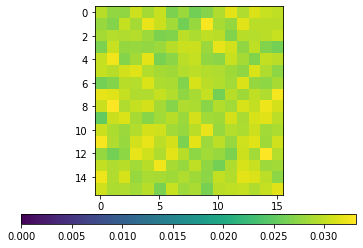

In [36]:
vmax = 0.0
vmin = 0.0
for i in range(N_DENSE):
    cur_w = mid_layer.get_weights()[0][:,-(i+1)]
    if max(cur_w) > vmax:
        vmax = max(cur_w)
    
    if min(cur_w) < vmin:
        vmin = min(cur_w)
        

fig, (axes, ax_color) = plt.subplots(2,N_DENSE, gridspec_kw={"height_ratios":[1, 0.05]})
im_list = []
axes_iter = None
if N_DENSE > 1:
    for i, ax in enumerate(axes.flat):
        im = ax.imshow(mid_layer.get_weights()[0][:,-(i+1)].reshape(L,L), vmin=vmin, vmax=vmax)
        im_list.append(im)

    for i, ax in enumerate(ax_color.flat):
        fig.colorbar(im_list[i], cax=ax, orientation="horizontal")
else:
        im = axes.imshow(mid_layer.get_weights()[0][:,-(i+1)].reshape(L,L), vmin=vmin, vmax=vmax)
        im_list.append(im)
        fig.colorbar(im_list[0], cax=ax_color, orientation="horizontal")
        #plt.colorbar(x=axes, orientation="horizontal")

#plt.savefig("{}/s3-bucket/ising/ae_weights_as_image_l{}".format(prefix_s3, L))
plt.savefig("{}/s3-bucket/ising/linear_ae_latent_space_build_up_for_pca_compare/ae_weights_as_image_l{}_n_dense_{}".format(prefix_s3, L, N_DENSE))

In [ ]:
max(mid_layer.get_weights()[0][:,-(i+1)])

In [ ]:
full_latent_out = simp_ae.predict(filterned_confs.drop(["T","M"], axis=1))

In [ ]:
plt.scatter(pd.to_numeric(filterned_confs["M"]), full_latent_out[:,0], c=pd.to_numeric(filterned_confs["T"]), alpha=0.1)
plt.xlabel("magnitization")
plt.ylabel("1st")
plt.savefig("{}/s3-bucket/reproduction/fig_2/ae_scatter_latent_vs_mag_color_by_t_l{}.png".format(prefix_s3, L))

# Simple AE Latent Space

In [ ]:
#mid_layer = simp_ae.get_layer('latent_space')
#mid_layer.output()

In [ ]:
extractor = keras.Model(inputs=simp_ae.inputs,
                        outputs=[layer.output for layer in simp_ae.layers])

In [ ]:
extractor

In [ ]:
features = extractor(filterned_confs.drop(["T","M"], axis=1).to_numpy())

In [ ]:
features[0].shape

In [ ]:
features[0][:,0]

In [ ]:
plt.scatter(features[0][:,2], features[0][:,1], c=filterned_confs["T"])

# Simple Autoencoder with Reshape

In [ ]:
simp_ae = tf.keras.Sequential(
    [
        keras.layers.InputLayer(input_shape=(L, L, 1)),
        keras.layers.Flatten(),
        keras.layers.Dense(N_DENSE, use_bias=False, name='latent_space'),
        keras.layers.Dense(units=L*L),
        keras.layers.Reshape(target_shape=(L, L, 1))
    ]
)

# Fig 2.c

In [ ]:
filterned_confs["latent_1"] = full_latent_out[:,0]

In [ ]:
from sqlalchemy import create_engine
engine = create_engine('sqlite://', echo=False)

In [ ]:
filterned_confs.to_sql('filtered_confs', con=engine, if_exists='append')

In [ ]:
avg_m_out = engine.execute(
"""
    select 
        t,
        avg(abs(m)),
        avg(abs(latent_1))
    from filtered_confs
    group by t
""").fetchall()

In [ ]:
avg_m_out[1:]

In [ ]:
plt.plot(
    [i[0] for i in avg_m_out[1:]],
    [i[1] for i in avg_m_out[1:]],
    c='r',
    label="magnetization"
)
plt.plot(
    [i[0] for i in avg_m_out[1:]],
    [i[2] for i in avg_m_out[1:]],
    c='b',
    label="latent param."
)
plt.xlabel("Temperature")
plt.legend()
plt.savefig("{}/s3-bucket/reproduction/fig_2/pca_magnitization_and_latent_param_vs_temp_l{}.png".format(prefix_s3, L))

# Look into this

In [ ]:
#engine.execute(
#"""
#    select 
#    m
#    from filterned_confs
#    where t is null
#""").fetchall()

# Simple AE Recreate from Latent Space

In [ ]:
recreate_sample_size = 10

plt.figure(figsize=(3, recreate_sample_size*2))

sampled_look = filterned_confs.drop(["T","M"], axis=1).sample(recreate_sample_size)
sampled_latent_out = simp_ae.predict(sampled_look)

for i in range(recreate_sample_size):
    
    plt1 = plt.subplot2grid((recreate_sample_size,2), (i,0), colspan=1)
    plt2 = plt.subplot2grid((recreate_sample_size,2), (i,1), colspan=1)
    
    plt1.imshow(
        sampled_look.iloc[i].to_numpy().reshape(L,L)
    )
    plt2.imshow(
        sampled_latent_out[i].reshape(L,L)
    )
